In [1]:
from FedADMM_models import *
from utils import *

In [2]:
## uncomment for colab
## upload datasetGenerator.py for preprocessing dataset

# from google.colab import drive
# drive.mount('/content/drive')
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/BVP.zip"
# ! python /content/datasetGenerator.py

In [3]:
fraction_for_test = 0.15
num_class = 4
ALL_MOTION = [i for i in range(1, num_class+1)]
N_MOTION = len(ALL_MOTION) # Number of output classes
T_MAX = 38 # Number of timestamps
n_gru_hidden_units = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

destination_folder = './results'
try:
    os.makedirs(destination_folder)
except:
    pass

# Model

In [4]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2, padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 10 * 10, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.cnn(x)

class ConvGRUModel(nn.Module):
    def __init__(self, hidden_size, num_classes, num_timestamps):
        super(ConvGRUModel, self).__init__()
        
        # CNN module for each input timestamp
        self.cnn_modules = nn.ModuleList([
            CNNModule() for _ in range(num_timestamps)
        ])
        
        # GRU layers
        self.gru = nn.GRU(32, hidden_size, num_layers=num_timestamps, batch_first=True, dropout=0.25)

        # Fully connected layer at the output of last GRU
        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Relu activation for fully connected
        self.relu = nn.ReLU()
        # Softmax activation for classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply CNN module sequentially for each timestamp
        x = x.unsqueeze(2)
        x = np.swapaxes(x, 0, 1)
        x = [module(xi) for module, xi in zip(self.cnn_modules, x)]
        x = torch.stack(x, dim=1)  # Stack along the time dimension
        
        # GRU layer
        x, _ = self.gru(x)

        # Apply ReLU activation after the GRU layer
        x = self.relu(x)

        # Fully connected layer at the output of last GRU
        x = self.fc_out(x[:, -1, :])
        
        # Softmax for classification
        x = self.softmax(x)

        return x

## Load dataset

In [5]:
# Load datasets
num_clients = 5
batch_size = 128
client_datasets = {}
client_loaders = {}

for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./data/data{i}.pt')
    data = torch.from_numpy(client_data['data']).float()
    label = torch.from_numpy(client_data['label']).long()

    # Split data into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(
        data, label, test_size=fraction_for_test, random_state=42
    )

    train_dataset = TensorDataset(data_train, label_train)
    test_dataset = TensorDataset(data_test, label_test)
    client_datasets[f'client{i}'] = {'train': train_dataset, 'test':test_dataset}

    # Set up data loaders for each client's
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    client_loaders[f'client{i}'] = {'train': train_loader, 'test':test_loader}

## FedADMM

In [6]:
fed_admm = FedADMMAlgorithm(model=ConvGRUModel,
                            n_gru_hidden_units=n_gru_hidden_units, 
                            num_class=N_MOTION, 
                            timestamp=T_MAX, 
                            train_loader=client_loaders,                                    
                            rho=0.01
                            )

fed_admm_round_accuracy, fed_admm_result = fed_admm.run(num_rounds=10, 
                                                        num_epochs=4
                                                        )
# Save to a file using pickle
with open('fed_admm_result.pkl', 'wb') as file:
    pickle.dump(fed_admm_result, file)
    
with open('fed_admm_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_admm_round_accuracy, file)

---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 1.3861, Train Accuracy: 25.80%, Val Loss: 1.3858, Val Accuracy: 26.09%
        Epoch: 2, Train Loss: 1.3858, Train Accuracy: 25.20%, Val Loss: 1.3857, Val Accuracy: 26.09%
        Epoch: 3, Train Loss: 1.3855, Train Accuracy: 26.20%, Val Loss: 1.3857, Val Accuracy: 26.09%
        Epoch: 4, Train Loss: 1.3856, Train Accuracy: 26.23%, Val Loss: 1.3855, Val Accuracy: 26.09%

Training on Client 2
        Epoch: 1, Train Loss: 1.3588, Train Accuracy: 36.38%, Val Loss: 1.3688, Val Accuracy: 33.60%
        Epoch: 2, Train Loss: 1.3442, Train Accuracy: 37.67%, Val Loss: 1.3761, Val Accuracy: 33.60%
        Epoch: 3, Train Loss: 1.3462, Train Accuracy: 37.67%, Val Loss: 1.3710, Val Accuracy: 33.60%
        Epoch: 4, Train Loss: 1.3471, Train Accuracy: 37.67%, Val Loss: 1.3681, Val Accuracy: 33.60%

Training on Client 3
        Epoch: 1, Train Loss: 1.3523, Train Accuracy: 36.98%, Val Loss: 1.3648, Val Accuracy:

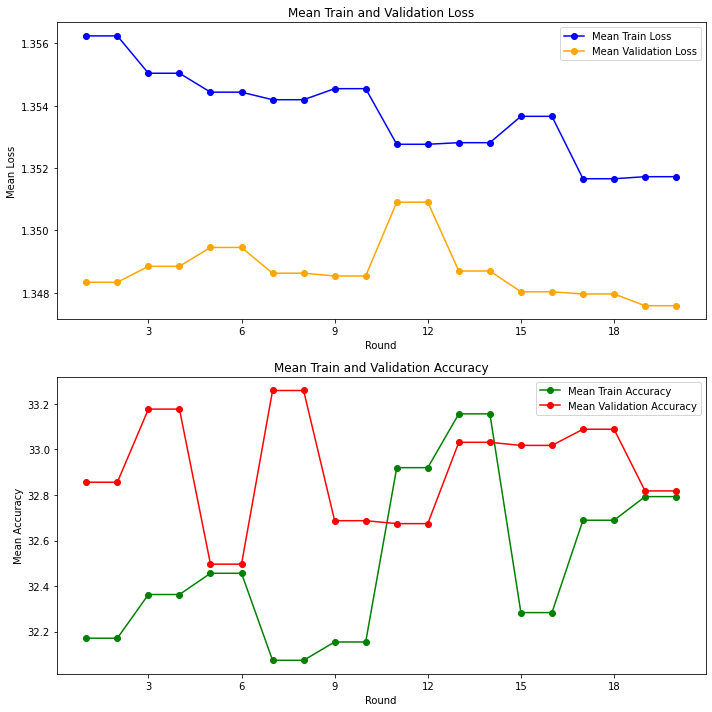

In [7]:
plot_result(fed_admm_result)

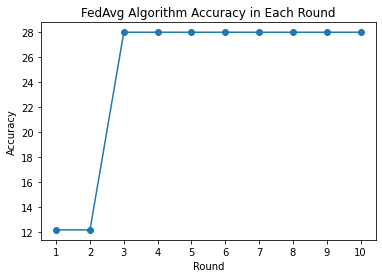

In [8]:
rounds = range(1, len(fed_admm_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_admm_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()